In [1]:
from torchvision.datasets import ImageNet
from torchvision import transforms
image_size = 224
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
])
data_dir = "/data1/linkdom/data/ImageNet"
train_dataset = ImageNet(data_dir, split='train', transform=transform)
val_dataset = ImageNet(data_dir, split='val', transform=transform)

In [3]:
import torch
from torch import Tensor
from einops import rearrange

def random_mask(
        x: Tensor,
        mask_prob: float,
    ) -> Tensor:
    """
    mask the `[B, T, C]` Tensor x on dim `T`
    with the specified probability
    """
    B, T, C = x.size()
    # Generate random probabilities for each frame
    rand_probs = torch.rand(B, T, device=x.device)
    mask = (rand_probs > mask_prob).unsqueeze(-1).type(x.dtype)
    x = x * mask
    return x


def patch_mask(
        x: Tensor,
        mask_prob: float,
        patch_size: int,
    ) -> Tensor:
    """
    mask the `[B, C, H, W]` Tensor x on dim `H` and `W`
    with the specified probability and patch size
    """
    assert x.dim() == 4, f"Expected 4D input, got {x.dim()}"
    B, C, H, W = x.size()
    assert H % patch_size == 0, f"Height {H} is not divisible by patch size {patch_size}"
    assert W % patch_size == 0, f"Width {W} is not divisible by patch size {patch_size}"
    nH, nW = H // patch_size, W // patch_size
    x = rearrange(
        x, 'B C (nH Hs) (nW Ws) -> B (nH nW) (C Hs Ws)', 
        Hs = patch_size, Ws = patch_size
    )
    x = random_mask(x, mask_prob)
    x = rearrange(
        x, 'B (nH nW) (C Hs Ws) -> B C (nH Hs) (nW Ws)', 
        Hs = patch_size, Ws = patch_size, nH = nH, nW = nW
    )
    return x


In [4]:
import torch
from einops import rearrange
from torch import Tensor
from torch.utils.data import DataLoader

def show_images(images:Tensor):
    return transforms.ToPILImage()(images)

def make_grid(images:Tensor, ncol: int):
    images = rearrange(images, '(nr nc) c h w -> c (nr h) (nc w)', nc=ncol)
    return images

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
print(len(train_loader), len(val_loader))

40037 1563


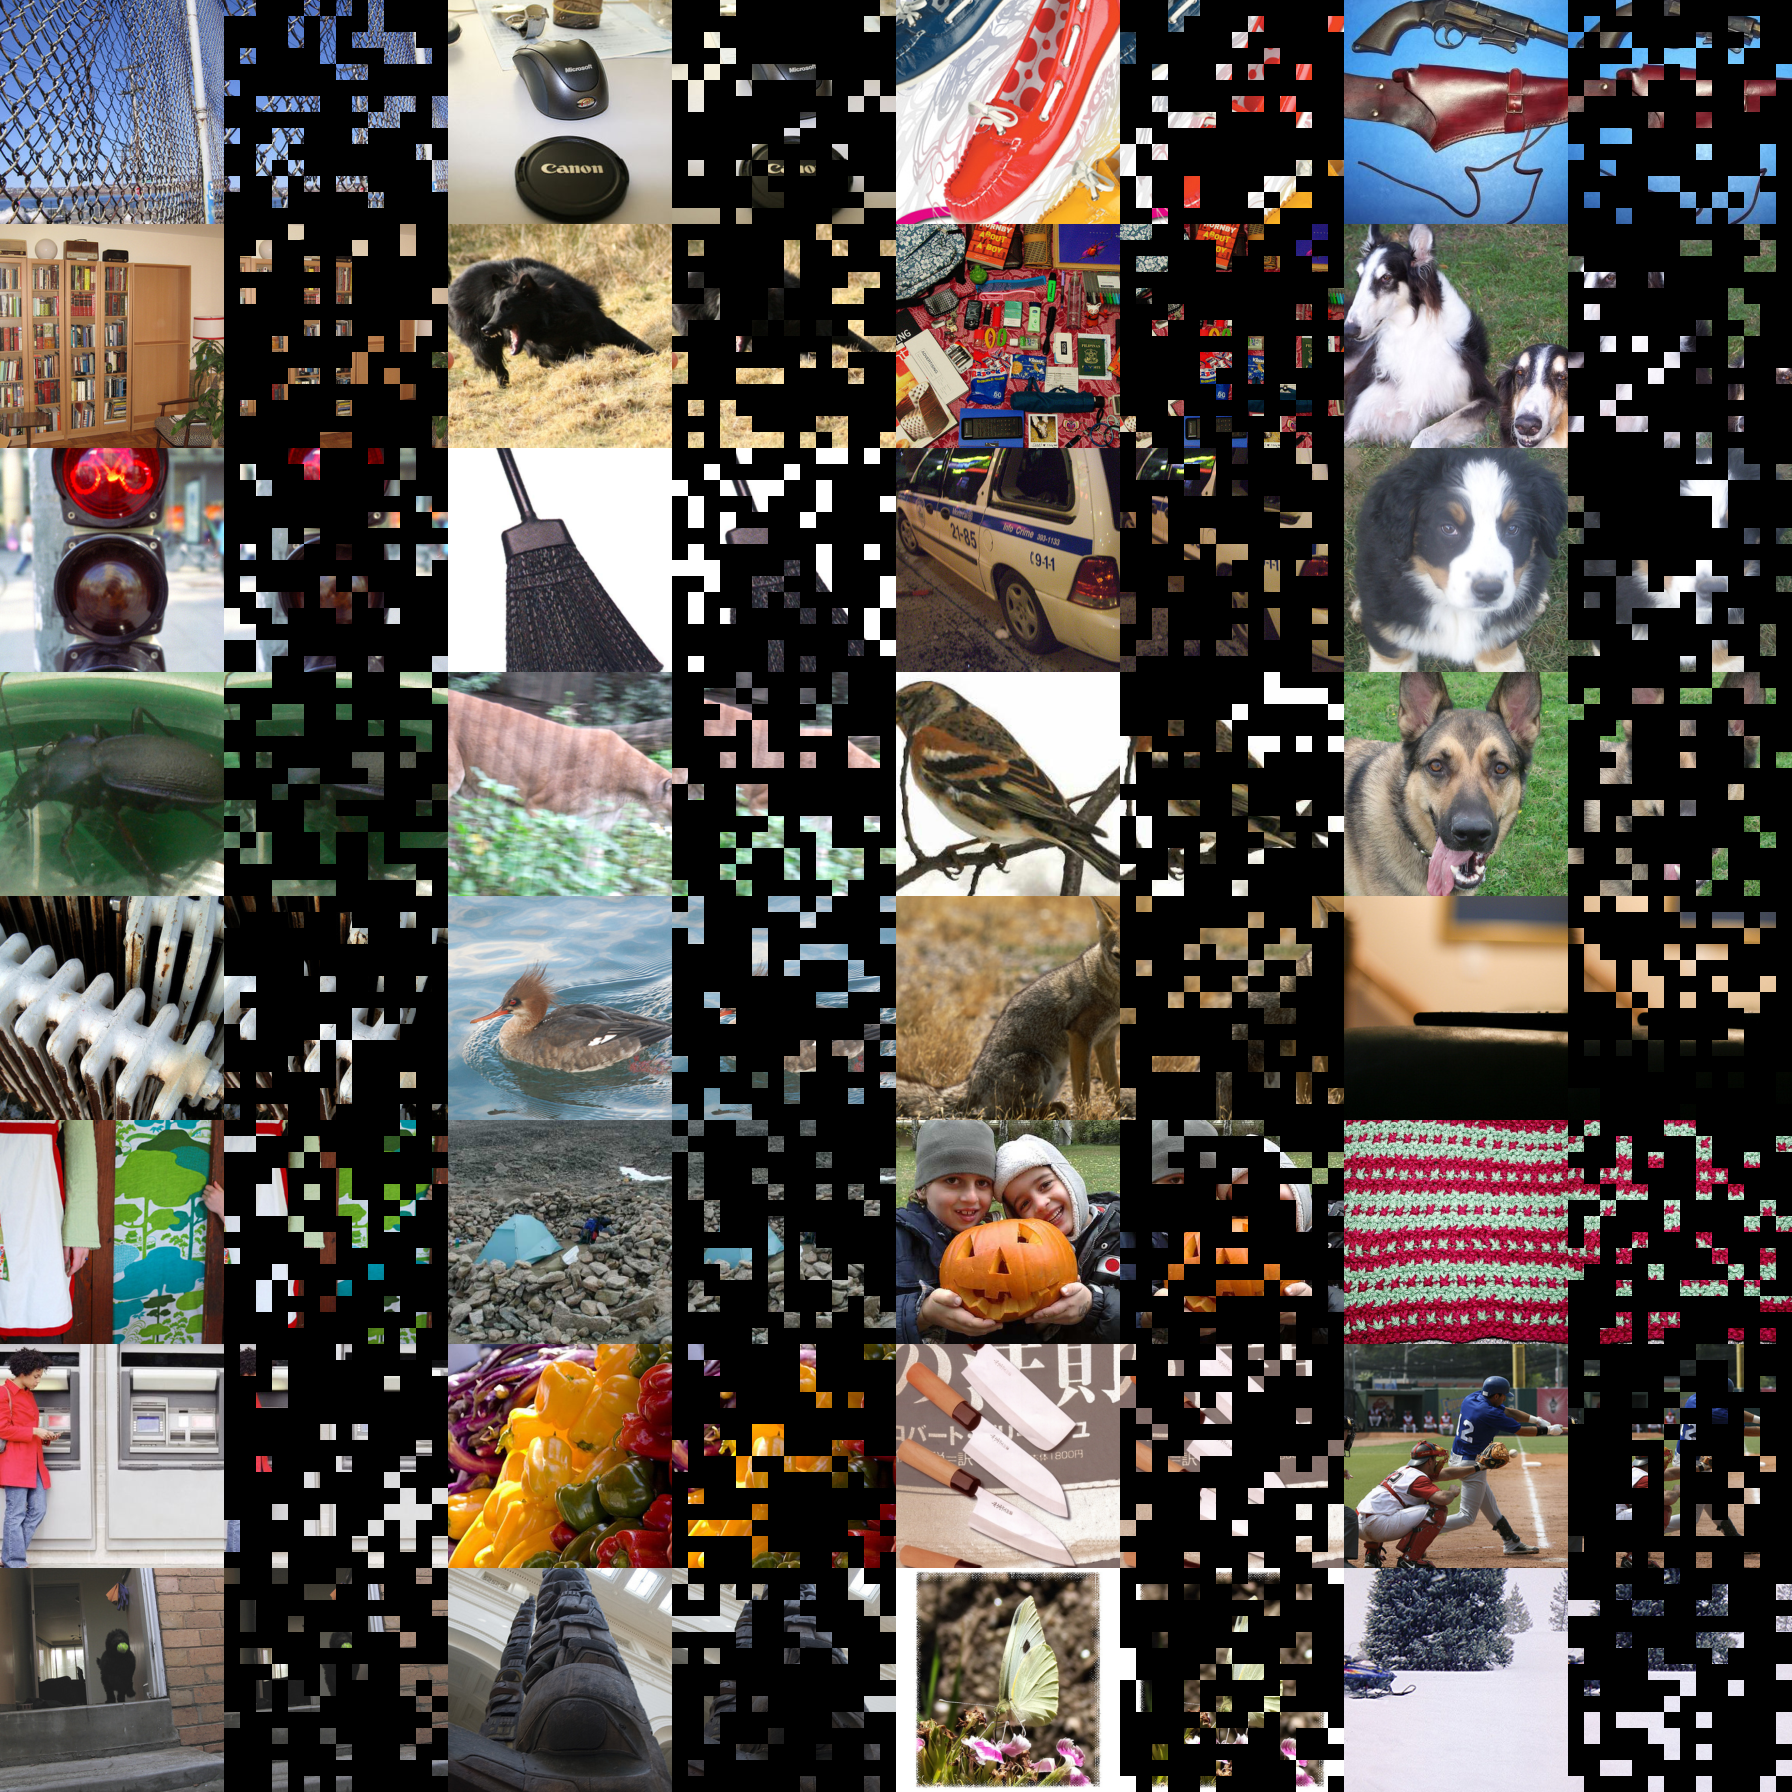

In [6]:
origin_images, _ = next(iter(train_loader))
masked_images = patch_mask(origin_images, mask_prob=0.75, patch_size=16)

origin_grid = make_grid(origin_images, 1)
masked_grid = make_grid(masked_images, 1)

concat_grid = torch.cat([origin_grid, masked_grid], dim=-1)

concat_grid = rearrange(concat_grid, 'c (b h) w -> b c h w', h = image_size)
concat_grid = make_grid(concat_grid, 4)

show_images(concat_grid)